# Chapter 2: 

# Tinh chỉnh tham số cho mô hình 

Chương 1 chỉ ra rằng khi K = 1 thì mô hình KNN là chưa đủ tốt để chúng ta có thể sử dụng. Tìm kiếm tham số tối ưu sao cho khả năng phân loại - dự báo của mô hình cao nhất có thể được là mấu cơ bản của việc xây dựng và huấn luyện một mô hình học máy. 

Trong chương này chúng ta sẽ tìm hiểu việc thực hiện tinh chỉnh tham số nhằm tìm kiếm tham số tối ưu cho mô hình. Để minh họa KNN sẽ được lựa chọn vì mô hình này đơn giản nhất và chỉ có một tham số là số láng giềng gần nhất. Dữ liệu sử dụng vẫn là bộ *UniversalBank.csv* đã được sử dụng trong chương 1. Dựa trên chiến lược tinh chỉnh tham số cho KNN thì chương này cũng trình bày cách thức tinh chỉnh cho mô hình có nhiều tham số là Support Vector Machine (SVM). 

# 2.1 Tinh chỉnh theo phương pháp Manual Search

Tinh chỉnh tham số cho mô hinh theo phương pháp này được tiến hành như sau. Trước hết liệt kê ra một số giá trị của tham số (hoặc một sự kết hợp nào đó của các tham số). Ứng với mỗi giá trị của tham số chúng ta huấn luyện mô hình trên cùng bộ dữ liệu train và kiểm tra ngược lại chất lượng của mô hình trên cùng bộ dữ liệu test để đánh giá xem với giá trị nào của tham số thì khả năng dự báo của mô hình là tốt nhất. 

Để minh họa chúng ta hãy xét mô hình KNN. Đây là mô hình chỉ có một tham số là số láng giềng gần nhất k. Trước hết là đọc dữ liệu và thực hiện chuẩn bị dữ liệu: 

In [1]:
# Đọc dữ liệu: 
import pandas as pd
df_bank = pd.read_csv("C:/Users/Zbook/Desktop/DataMining/dmba/UniversalBank.csv")

In [2]:
#============================
#   Chuẩn bị dữ liệu 
#============================

# Bỏ biến không cần thiết: 
my_df_binary = df_bank.drop(["ZIP Code", "ID"], axis=1) 

# Tách ra features và target: 
Y = my_df_binary["CreditCard"]
X = my_df_binary.drop("CreditCard", 1)

# Phân chia dữ liệu theo tỉ lệ 60 - 40: 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, random_state = 29, stratify = Y)

Số K láng giềng gần nhất sẽ là một số nguyên nhưng **không phải là số chẵn**. Trước hết chúng ta xem xét mô hình KNN với hai giá trị lẻ của K là 1 và 3 như sau: 

Text(0.5,1,'Figure 1: Mô hình KNN khi K = 1')

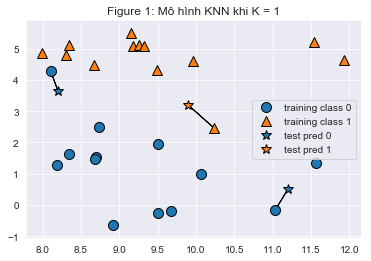

In [3]:
# Import một số thư việc cần thiết cho hình ảnh hóa dữ liệu: 
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")

import mglearn as mglearn
mglearn.plots.plot_knn_classification(n_neighbors=1)
plt.title("Figure 1: Mô hình KNN khi K = 1")

Còn với k = 3: 

Text(0.5,1,'Figure 2: Mô hình KNN khi K = 3')

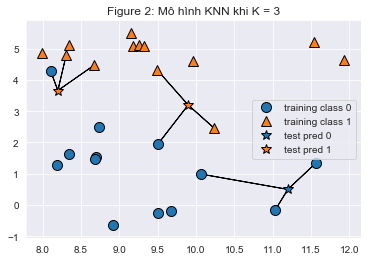

In [4]:
mglearn.plots.plot_knn_classification(n_neighbors=3)
plt.title("Figure 2: Mô hình KNN khi K = 3")

Trong không gian hai chiều, giả sử chúng ta có ba quan sát là những điểm hình sao. Nếu K = 1 thì chúng ta chỉ cần tìm ra duy nhất một quan sát nào mà gần nhất với ba quan sát trên. Vì rằng quan sát gần nhất với hình sao thứ nhất (hinh sao trên cùng, phía trái) là màu xanh nên mô hình KNN sẽ dự báo quan sát đó là màu xanh. Lập luận tương tự thì KNN sẽ dự báo hai quan sát còn lại lần lượt là vàng và xanh (Figure 1). 

Tuy nhiên nếu K = 3 thì với mỗi một quan sát thì KNN sẽ tìm kiếm 3 quan sát gần nhất với ba điểm hình sao. Trong 3 quan sát gần nhất với điểm hình sao thứ nhất thì có hai quan sát là màu vàng và chỉ có một quan sát là xanh. Trong tình huống này KNN sẽ dự báo điểm hình sao thứ nhất này là màu vàng - chính là màu chiếm đa số trong số 3 láng giềng gần nhất của nó. Tương tự thì điểm hình sao thứ 2 cũng là màu vàng. Với hình sao thứ ba thì điểm hình sao này KNN sẽ dự báo có màu xanh (Figure 2). 

Nếu K = 4 thì rất có thể xẩy ra tình huống sau: 4 láng giềng gần nhất của một quan sát mà KNN cần dự đoán màu thì sẽ có 2 hàng xóm màu vàng, 2 hàng xóm màu đỏ. Lúc này KNN sẽ thất bại trong việc dự báo màu cho quan sát mà chúng ta quan tâm. 

Do vậy khi huấn luyện và tinh chỉnh mô hình KNN thì số láng giềng K không nên là số chẵn. Để thực hiện tìm kiếm K tối ưu trước hết chúng ta viết một hàm với đầu vào là K được chọn và kết quả nhận được sẽ là Accuracy. Cụ thể hơn, hàm này sẽ huấn luyện mô hình KNN trên train data ứng với mỗi một K được chọn và sử dụng test data để tính toán Accuracy. Hàm này chúng ta đặt tên là **get_accuracy_k()**. 

In [5]:
# Load các thư viện cần thiết: 
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Viết hàm get_accuracy_k: 

def get_accuracy_k(k_selected):
    
    # Huấn luyện KNN model với k được chọn: 
    knn_k = KNeighborsClassifier(n_neighbors = k_selected)
    knn_k.fit(X_train, y_train)
    
    # Sử dụng KNN cho dự báo và tính Accuracy: 
    y_pred = knn_k.predict(X_test)
    acc = np.mean(y_pred == y_test)
    return(acc)

Với K = 1 thì chúng ta có kết quả sẽ là 0.576 như đã biết ở chương 1: 

In [6]:
get_accuracy_k(k_selected=1)

0.576

In [7]:
# Accurcy khi k = 3: 

In [8]:
get_accuracy_k(k_selected=3)

0.6095

Để khảo sát chất lượng phân lọai của mô hình KNN chúng ta có thể khảo sát các giá trị lẻ của K từ 1 đến 31 rồi tính toán Accuracy tương ứng như sau: 

In [9]:
# Thiết lập một dải giá trị của K:   
k = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

# Tạo ra array trống lưu dữ liệu: 
testing_accuracy = []

# Viết vòng lặp for loop tính toán Accuracy tương ứng với một giá trị của K: 
for i in k:  
    acc = get_accuracy_k(k_selected = i)   
    testing_accuracy.append(acc)

In [10]:
# Xem 3 kết quả đầu: 
testing_accuracy[0:3] 

[0.576, 0.6095, 0.6365]

Chất lượng phân loại của mô hình KNN tương ứng với các giá trị  khác nhau của K: 

Text(0.5,1,'Figure 3: Accuracy vs K khi random_state = 29')

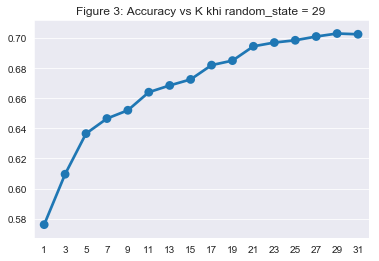

In [11]:
# Minh họa Accuracy khi K thay đổi: 
df_results = {"K": k, "Accuracy": testing_accuracy}
sns.pointplot(x="K", y="Accuracy", data = df_results)
plt.title("Figure 3: Accuracy vs K khi random_state = 29")

Figure 3 lôi kéo chúng ta đến kết luận rằng: k = 29 là giá trị tối ưu vì đó là giá trị của tham số mà Accuracy cao nhất. Liệu kết luận này có đúng? 

Câu trả lời là chưa chắc đúng. Vì rằng những gì chúng ta thấy ở trên mới chỉ dựa trên **một mẫu** số liệu mà thôi. Mẫu số liệu này tương ứng với lựa chọn random_state = 29. Nếu chọn, ví dụ, random_state = 88 thì kết quả lại cho thấy khi K = 27 chứ không phải 29 thì Accuracy của mô hình sẽ là cao nhất: 

Text(0.5,1,'Figure 4: Accuracy vs K khi random_state = 88')

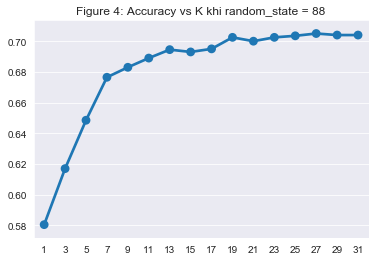

In [12]:
# Thử nghiệm lại với bộ dữ liệu train và test data khác: 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, random_state = 88, stratify = Y)

testing_accuracy = []

# Viết vòng lặp for loop tính toán Accuracy tương ứng với một giá trị của K: 
for i in k:  
    acc = get_accuracy_k(k_selected = i)   
    testing_accuracy.append(acc)
     
df_results = {"K": k, "Accuracy": testing_accuracy}
sns.pointplot(x="K", y="Accuracy", data = df_results)
plt.title("Figure 4: Accuracy vs K khi random_state = 88")    

Vậy thì tham số tối ưu là 27 hay 29 hay thậm chí là một giá trị nào khác?. Để trả lời câu hỏi này chúng ta cần tiếp cận theo hướng như sau. Chuẩn bị sẵn, ví dụ, 5 bộ dữ liệu train và test tương ứng. Khi K = 1 chạy 5 mô hình KNN trên 5 bộ dữ liệu train và tính Accuracy tương ứng với 5 bộ test data. Tính trung bình cho Accuracy. Lặp lại quá trình này cho đến giá trị cuối cùng là 29. Giá trị nào của K mà tạo ra Accuracy trung bình cao nhất thì giá trị đó gần như là tham số tối ưu của mô hình KNN. Rất may mắn là thư viện Scikit-Learn có những hàm cho phép chúng ta thực hiện chiến lược tinh chỉnh tham số này. 

# 2.2 Tinh chỉnh tham số bằng K Fold Cross-Validation 

Đây là một cách tiếp cận phổ biến để tinh chỉnh tham số của các mô hình học máy. Để minh họa chúng ta xét 5 Fold Cross-Validation như minh họa dưới đây: 

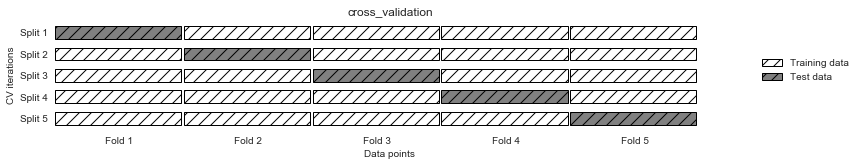

In [13]:
# Minh họa cho 5 Fold Cross-Validation: 
mglearn.plots.plot_cross_validation()

Ở đây bộ dữ liệu ban đầu sẽ được chia thành 5 phần xấp xỉ bằng nhau (mỗi phần gọi là một Fold). Như vậy theo cách chọn mẫu kiểu này chúng ta có 5 phần dữ liệu. Bốn trong số năm phần dữ liệu này sẽ được sử dụng để xây dựng mô hình và phần dữ liệu còn lại sẽ được sử dụng để kiểm tra ngược lại chất lượng của mô hình. Theo phương pháp 5 Fold Cross-Validation thì chúng ta sẽ có 5 giá trị tương ứng của, ví dụ,  Accuracy nếu chọn tiêu chí này để đánh giá mô hình. Dưới đây là Python codes để thực hiện 5 Fold Cross-Validation bằng hàm **cross_val_score()** của thư viện Scikit-Learn: 

In [14]:
# Thực hiện 5 Fold Cross-Validation cho KNN với K = 1: 
knn1 = KNeighborsClassifier(n_neighbors=1)
from sklearn.model_selection import cross_val_score
scores_from_cross = cross_val_score(knn1, X, Y, cv = 5)

In [15]:
# Xem 5 giá trị của Accuracy tương ứng: 
scores_from_cross

array([0.578, 0.582, 0.596, 0.562, 0.59 ])

In [16]:
# Có thể tính trung bình Accuracy của KNN khi K = 1 với 5 lần thử nghiệm: 
np.mean(scores_from_cross)

0.5815999999999999

Để hỗ trợ quá trình tinh chỉnh tham số cho KNN chúng ta viết hàm trả về trung bình Accuracy tương ứng với một giá trị được chọn của K khi sử dụng 5 Fold Cross-Validation: 

In [17]:
def get_average_acc(k_selected): 
    knn = KNeighborsClassifier(n_neighbors=k_selected)
    acc_5Fold = cross_val_score(knn, X, Y, cv = 5)
    avg_acc = np.mean(acc_5Fold)
    return(avg_acc)

Kế tiếp viết vòng lặp for loop tính toán các trung bình Accuracy này cho một dải các giá trị của K: 

In [18]:
# Tạo ra array trống lưu dữ liệu: 
avg_accuracy = []

# Tính toán trung bình Accuracy tương ứng với một giá trị của K: 
for i in k:  
    acc_mean = get_average_acc(k_selected = i)   
    avg_accuracy.append(acc_mean)

Sự biến đổi của trung bình Accuracy theo K chỉ ra rằng K = 31 chính là giá trị tham số tối ưu chứ không phải là 27 hay 29: 

Text(0.5,1,'Figure 5: Average Accuracy dựa trên 5 Fold Cross-Validation')

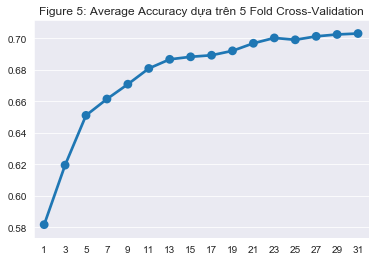

In [19]:
df_results_5Fold = {"K": k, "Avg_Acc": avg_accuracy}
sns.pointplot(x="K", y="Avg_Acc", data = df_results_5Fold)
plt.title("Figure 5: Average Accuracy dựa trên 5 Fold Cross-Validation")  

Chúng ta có thể chỉ ra giá trị lớn nhất này là 70.3% và lưu ý rằng đây là Accuracy trung bình từ thử nghiệm 5 mẫu: 

In [20]:
np.max(avg_accuracy)

0.703

Với kết quả này chúng ta có thể huấn luyện lại KNN với K = 31 đồng thời đánh giá mức độ chính xác khi phân loại trên test data: 

In [21]:
knn31 = KNeighborsClassifier(n_neighbors=31)
knn31.fit(X_train, y_train).score(X_test, y_test)

0.704

# 2.3 Tinh chỉnh tham số bằng Grid Search

Hầu hết các mô hình ML đều có nhiều hơn một tham số. Chẳng hạn Support Vector Machine (SVM) có hai tham số là *gamma* và *C*. Giả sử dựa trên hiểu biết và kinh nghiệm về SVM chúng ta chọn ra 6 giá trị cho tham số gamma và 6 giá trị cho tham số C. Như vậy chúng ta có tất cả là 6*6 = 36 sự kết hợp khác nhau của hai tham số này. 

Tinh chỉnh tham số theo cách tiếp cận Grid Search chính là tìm ra sự kết hợp nào của các tham số sẽ làm cho mô hình có chất lượng dự báo tốt nhất. Python codes dưới đây trình bày phương án tinh chỉnh tham số bằng Grid Search cho mô hình SVM. 

In [22]:
# Load estimator SVC từ thư viện Scikit-Learn cho mô hình SVM: 
from sklearn.svm import SVC

Để thực hiện chiến lược tìm kiếm tham số tối ưu cho SVM bằng Grid Search, chúng ta có thể sử dụng vòng lặp for loop. Để hỗ trợ việc tìm kiếm tham số tối ưu (hiểu trong tình huống này là sự  kết hợp tối ưu của các tham số) chúng ta nên tạo ra một object có tên là *best_score* có giá trị là 0 và chúng ta chỉ ghi nhận sự kết hợp nào của các tham số mà có Accuracy lớn hơn 0 cho lần chạy đầu tiên, các lần chạy sau thì Accuracy được so sánh với lần chạy trước. Mục tiêu là chúng ta chỉ cần tìm ra sự kết hợp nào của tham số tạo ra Accuracy cao nhất. Các giá trị tiềm năng cho hai tham số gamma và C là 6 giá trị [0.001, 0.01, 0.1, 1, 10, 100]. 

In [23]:
# Đặt ngưỡng lựa chọn: 
best_score = 0

# Vòng lặp for loop tinh chỉnh tham số theo cách tiếp cận Grid Search: 
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        
        # Kích hoạt, tinh chỉnh và tính toán Accuracy: 
        my_svm = SVC(gamma=gamma, C=C)
        score = my_svm.fit(X_train, y_train).score(X_test, y_test)
        
        # Đối chiếu với ngưỡng đã chọn và lưu lại giá trị cao nhất: 
        if score > best_score:
            best_score = score
            best_parameters = {"C": C, "gamma": gamma}

Kết quả tốt nhất và tham số tối ưu tương ứng: 

In [24]:
print("best score: ", best_score)
print("best parameters: ", best_parameters)

best score:  0.706
best parameters:  {'C': 0.001, 'gamma': 0.001}


Đến đây chúng ta có thể chạy lại SVM trên train data với tham số tốt nhất tìm được và đánh giá chất lượng của mô hình SVM trên test data. Đương nhiên kết quả Accuracy chúng ta sẽ biết trước là 70.6%: 

In [25]:
best_svm1 = SVC(**best_parameters) # Hoặc có thể thay thế bằng best_svm = SVC(gamma=0.001, C=0.001)
best_svm1.fit(X_train, y_train).score(X_test, y_test)

0.706

Phải chăng *gamma = 0.001, C = 0.001* tạo ra Accuracy = 0.706 có phải là sự kết hợp tối ưu không? Câu trả lời là: có thể không phải. Đơn giản và cũng giống như Manual Seach cho KNN mà chúng ta đã biết ở mục 2.1, kết quả 0.706 ở trên chỉ là kết quả của *tương ứng với một mẫu dữ liệu* và do vậy chúng ta không thể tổng quát hóa kết luận rằng sự kết hợp tối ưu của các tham số là gamma = 0.001, C = 0.001. Để tự tin hơn về giá trị tối ưu cho tham số chúng ta phải kết hợp với phương pháp Cross-Validation được trình bày dưới đây. 

# 2.4 Grid Search kết hợp Cross-Validation

Python Codes dưới đây thực hiện chiến lược tìm kiếm tham số tối ưu bằng Grid Search kết hợp với  5 Fold Cross-Validation: 

In [26]:
best_score5 = 0

# Vòng lặp for loop tinh chỉnh tham số theo cách tiếp cận Grid Search + cross-validation: 
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        
        my_svm = SVC(gamma=gamma, C=C)
        score_5Fold = cross_val_score(my_svm, X_train, y_train, cv = 5)
        
        # Tính mean cho 5 giá trị Accuracy: 
        mean_score = np.mean(score_5Fold)
        
        if mean_score > best_score5:
            best_score5 = mean_score
            best_parameters5Fold = {"C": C, "gamma": gamma}

Với Grid Search thì SVM sẽ được chạy 36 lần nhưng kết hợp với 5 Fold Cross-Validation thì con số sẽ là 36*5 = 180. Vì rằng một một sự kết hợp của tham số thì SVM tương ứng với cặp tham số gamma + C sẽ được chạy trên 5 mẫu dữ liệu khác nhau. Giá trị của tham số tối ưu thu được là C = 0.001 và gamma = 0.001 khi sử dụng cross-validation chỉ là sự trùng hợp: 

In [27]:
print("best parameters: ", best_parameters5Fold)

best parameters:  {'C': 0.001, 'gamma': 0.001}


Lúc này lưu ý rằng giá trị Accuracy = 0.7060004574086779 không phải là mức độ chính xác trên train data: 

In [28]:
print("Best score from 5 Fold Cross-Validation: ", best_score5)

Best score from 5 Fold Cross-Validation:  0.7060004574086779


Để tính toán Accuracy trên train data khi gamma = 0.001, C = 0.001 chúng ta phải huấn luyện lại SVM trên train data và sử dụng mô hình có được với test data để đánh giá chất lượng phân loại: 

In [29]:
# Huấn luyện lại SVM trên train data với tham số tối ưu: 
best_svm2 = SVC(**best_parameters5Fold)

# Tính Accuracy trên test data: 
best_svm2.fit(X_train, y_train).score(X_test, y_test)

0.706

Ở trên để thực hiện Grid Search kết hợp với Cross-Validation chúng ta viết vòng lặp for loop (thực ra là vòng lặp lồng vòng lặp). Vì rằng chiến lược tìm kiếm tham số tối ưu này là phổ biến nên thư viện Scikit-Learn hỗ trợ việc thực hiện tinh chỉnh tham số theo chiến lược này bằng hàm *GridSearchCV* theo cách thức sau: 

In [30]:
# Định nghĩa các ứng viên tiềm năng cho tham số: 
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100], "gamma": [0.001, 0.01, 0.1, 1, 10, 100]}

# Load GridSearchCV: 
from sklearn.model_selection import GridSearchCV

# Thiết lập môi trường tinh chỉnh: 
grid_search = GridSearchCV(SVC(), param_grid, cv=5)

# Huấn luyện trên dữ liệu: 
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Chúng ta có thể chỉ ra tham số tối ưu cùng Accuracy tương ứng: 

In [31]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 0.001, 'gamma': 0.001}
0.706


Chúng ta có thể tìm lại kết quả phân loại của SVM cho bộ dữ liệu test data theo hai cách:  

In [32]:
# Cách 1 (đã biết): 
best_svm3 = SVC(**grid_search.best_params_)
best_svm3.fit(X_train, y_train).score(X_test, y_test)

0.706

In [33]:
# Cách 2: 
grid_search.best_score_

0.706

# 2.5 Phân tích kết quả của Grid Search

Vai trò (hay ảnh hưởng) của các tham số đến chất lượng phân loại - dự báo của mô hình phụ thuộc vào nhiều yếu tố nhưng hai yếu tố đầu tiên mà chúng ta có thể liệt kê là: (1) Mô hình ML được chọn, và (2) Dữ liệu sử dụng để huấn luyện. Điều này cũng có nghĩa là tham số C có thể có vai trò lớn hơn gamma khi huấn luyện trên bộ dữ liệu A nhưng chưa chắc điều này đã đúng khi huấn luyện trên bộ dữ liệu B. 

Chúng ta có thể phân tích vai trò và ảnh hưởng của các tham số bằng một công cụ hình ảnh là Heat Map như sau: 

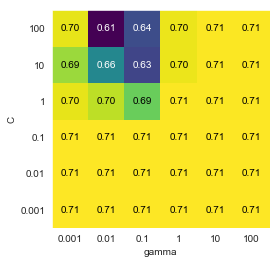

In [34]:
# Chuyển về Dataframe: 
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(6, 6)

# Heat Map cho thấy biến đổi của Accuracy theo các giá trị của tham số: 
mglearn.tools.heatmap(scores, xlabel="gamma", xticklabels=param_grid["gamma"],
                      ylabel="C", yticklabels=param_grid["C"], cmap="viridis")

Accuracy của SVM trong hầu hết tình huống là 71%. Điều này hàm ý rằng chất lượng của mô hình là "trơ", không nhạy với các giá trị khác nhau của tham số - ít nhất là trong dải tham số cho gamma và C mà chúng ta đã chọn. Để phân tích xa hơn vai trò của các tham số đối với chất lượng phân loại của mô hình chúng ta có thể thực hiện phân tích hình ảnh như sau: 

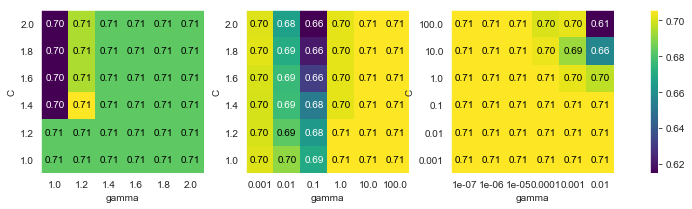

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(13, 3))

param_grid_linear = {"C": np.linspace(1, 2, 6), "gamma": np.linspace(1, 2, 6)}
param_grid_one_log = {"C": np.linspace(1, 2, 6), "gamma": np.logspace(-3, 2, 6)}
param_grid_range = {"C": np.logspace(-3, 2, 6), "gamma": np.logspace(-7, -2, 6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log,
                           param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_["mean_test_score"].reshape(6, 6)

    scores_image = mglearn.tools.heatmap(
        scores, xlabel="gamma", ylabel="C", xticklabels=param_grid["gamma"],
        yticklabels=param_grid["C"], cmap="viridis", ax=ax)

plt.colorbar(scores_image, ax=axes.tolist())

Panel đầu tiên chỉ ra rằng *các giá trị của C và gamma tác động rất yếu đến Accuracy* trong khoảng giá trị đã chọn cho gamma và C. Nếu điều này còn lặp lại với các khoảng giá trị khác của tham số gamma và C thì chúng ta có thể đi đến kết luận rằng *cần tinh chỉnh mô hình với một dải giá trị khác cho gamma và C*.  

# 2.6 Tóm tắt chương

Chương này trình bày chi tiết khía cạnh thực hành cho quá trình tinh chỉnh tham số cho mô hình học máy. Với mục đích minh họa thì KNN - mô hình ML chỉ có một tham số - được lựa chọn vì mức độ đơn giản và tính toán nhanh chóng của nó nhưng ý tưởng và cách tiếp cận cho việc tinh chỉnh tham số như đã biết có thể được áp dụng cho mọi mô hình học máy khác. 

Với mô hình nhiều tham số, SVM được lựa chọn để minh họa cho các chiến lược tinh chỉnh tham số từ đơn giản đến phức tạp. Một số cách tiếp cận khác tinh vi hơn cho tinh chỉnh tham số chưa được trình bày trong chương này. 

# Tài Liệu Tham Khảo

1. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning. New York: springer.

2. Kuhn, M., & Johnson, K. (2013). Applied predictive modeling. New York: Springer.

3. Müller, A. C., & Guido, S. (2016). Introduction to machine learning with Python: a guide for data scientists. "O'Reilly Media, Inc.".

4. Géron, A. (2019). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".

5. Shmueli, G., Bruce, P. C., Yahav, I., Patel, N. R., & Lichtendahl Jr, K. C. (2017). Data mining for business analytics: concepts, techniques, and applications in R. John Wiley & Sons. 

